In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
% matplotlib inline
plt.style.use('ggplot')

import seaborn as sns

import cartopy.crs as ccrs
import cartopy.feature as cfeat
import cartopy.io.img_tiles as cimgt

import AISMapPlot as aismap

In [2]:
# Load the data
names = ['TripID', 'MMSI', 'StartLatitude', 'StartLongitude', 'StartTime', 'EndLatitude', 'EndLongitude', 'EndTime',
         'StartPort', 'EndPort', 'ID', 'time', 'shiptype', 'Length', 'Breadth', 'Draught', 'Latitude', 'Longitude',
         'SOG', 'COG', 'TH', 'Destination', 'Name', 'Callsign', 'AisSourcen']
ais = pd.read_csv('rotterdam_hamburg.arff', names = names, skiprows = 27, parse_dates = True,
                  na_values = ['?'], dtype = {'TripID': str, 'MMSI': str, 'shiptype': str})

In [3]:
ais.head()

,TripID,MMSI,StartLatitude,StartLongitude,StartTime,EndLatitude,EndLongitude,EndTime,StartPort,EndPort,...,Draught,Latitude,Longitude,SOG,COG,TH,Destination,Name,Callsign,AisSourcen
0,21109,210481000,51.94,4.05,'2016-1-21 04:32',53.53,9.91,'2016-1-22 06:04',ROTTERDAM,HAMBURG,...,10.64,53.95,7.82,14.7,81.0,80.0,HAMBURG,CMA.CGM.SAMBHAR,5BND2,H7001.DAIS1.81b.71.71a
1,21109,210481000,51.94,4.05,'2016-1-21 04:32',53.53,9.91,'2016-1-22 06:04',ROTTERDAM,HAMBURG,...,10.64,53.95,7.83,14.7,80.0,80.0,HAMBURG,CMA.CGM.SAMBHAR,5BND2,H7001.DAIS1.81b.71.71a
2,21109,210481000,51.94,4.05,'2016-1-21 04:32',53.53,9.91,'2016-1-22 06:04',ROTTERDAM,HAMBURG,...,10.64,53.95,7.83,14.7,81.0,80.0,HAMBURG,CMA.CGM.SAMBHAR,5BND2,H7001.DAIS1.81b.71.71a
3,21109,210481000,51.94,4.05,'2016-1-21 04:32',53.53,9.91,'2016-1-22 06:04',ROTTERDAM,HAMBURG,...,10.64,53.95,7.84,14.7,80.0,80.0,HAMBURG,CMA.CGM.SAMBHAR,5BND2,H7001.DAIS1.81b.71.71a
4,21109,210481000,51.94,4.05,'2016-1-21 04:32',53.53,9.91,'2016-1-22 06:04',ROTTERDAM,HAMBURG,...,10.64,53.95,7.85,14.7,81.0,80.0,HAMBURG,CMA.CGM.SAMBHAR,5BND2,H7001.DAIS1.81b.71.71a


In [4]:
ais_nan = ais

In [5]:
# Convert time columns to correct dtype
ais_nan['StartTime'] = pd.to_datetime(ais_nan['StartTime'], format = '\'%Y-%m-%d %H:%M\'')
ais_nan['EndTime'] = pd.to_datetime(ais_nan['EndTime'], format = '\'%Y-%m-%d %H:%M\'')
ais_nan['time'] = pd.to_datetime(ais_nan['time'], format = '\'%Y-%m-%d %H:%M\'')

In [6]:
# Convert all headings that are 511 (>= 360) to NaN
ais_nan.loc[ais_nan['TH'] >= 360, 'TH'] = np.nan

In [7]:
# Convert courses >= 360 to NaN
ais_nan.loc[ais_nan['COG'] >= 360, 'COG'] = np.nan

In [8]:
# Set invalid shiptypes to NaN
# Invalid shiptypes existing in the data set are '0' and '159'
ais_nan.loc[(ais_nan['shiptype'] == '0') | (ais_nan['shiptype'] == '159'), 'shiptype'] = np.nan

In [9]:
# Set invalid lengths (0 or > 400) to NaN
ais_nan.loc[(ais_nan['Length'] <= 0) | (ais_nan['Length'] > 400), 'Length'] = np.nan

In [10]:
# Set invalid lengths (0 or > 59) to NaN
ais_nan.loc[(ais_nan['Breadth'] <= 0) | (ais_nan['Breadth'] > 59), 'Breadth'] = np.nan

In [11]:
# Set speeds that are unrealisticly high to NaN
ais_nan.loc[ais_nan['SOG'] > 25.6, 'SOG'] = np.nan

In [12]:
ais_dropped = ais_nan.drop(['AisSourcen', 'ID', 'StartPort', 'EndPort', 'Name', 'MMSI', 'shiptype'], axis = 1)

In [13]:
ais_dropped.head()

,TripID,StartLatitude,StartLongitude,StartTime,EndLatitude,EndLongitude,EndTime,time,Length,Breadth,Draught,Latitude,Longitude,SOG,COG,TH,Destination,Callsign
0,21109,51.94,4.05,2016-01-21 04:32:00,53.53,9.91,2016-01-22 06:04:00,2016-01-21 22:04:00,269.0,32.0,10.64,53.95,7.82,14.7,81.0,80.0,HAMBURG,5BND2
1,21109,51.94,4.05,2016-01-21 04:32:00,53.53,9.91,2016-01-22 06:04:00,2016-01-21 22:05:00,269.0,32.0,10.64,53.95,7.83,14.7,80.0,80.0,HAMBURG,5BND2
2,21109,51.94,4.05,2016-01-21 04:32:00,53.53,9.91,2016-01-22 06:04:00,2016-01-21 22:06:00,269.0,32.0,10.64,53.95,7.83,14.7,81.0,80.0,HAMBURG,5BND2
3,21109,51.94,4.05,2016-01-21 04:32:00,53.53,9.91,2016-01-22 06:04:00,2016-01-21 22:07:00,269.0,32.0,10.64,53.95,7.84,14.7,80.0,80.0,HAMBURG,5BND2
4,21109,51.94,4.05,2016-01-21 04:32:00,53.53,9.91,2016-01-22 06:04:00,2016-01-21 22:08:00,269.0,32.0,10.64,53.95,7.85,14.7,81.0,80.0,HAMBURG,5BND2


Text(0.5,1,u'All Positions Before Filtering')

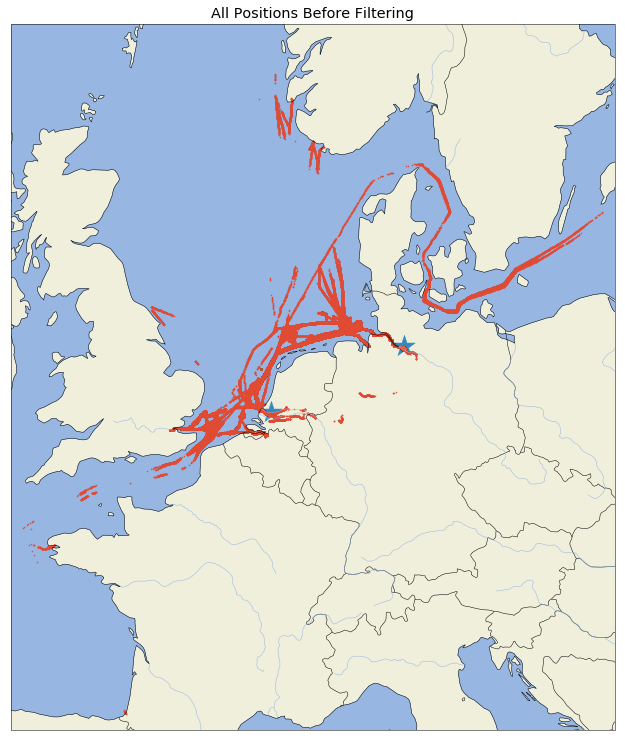

In [14]:
# Plot all positions in the data before any filters are applied
aismap.plot_to_map(size = (13, 13), longitude = ais_dropped['Longitude'], latitude = ais_dropped['Latitude'])
plt.title("All Positions Before Filtering")

Text(0.5,1,u'Start Positions Before Filtering')

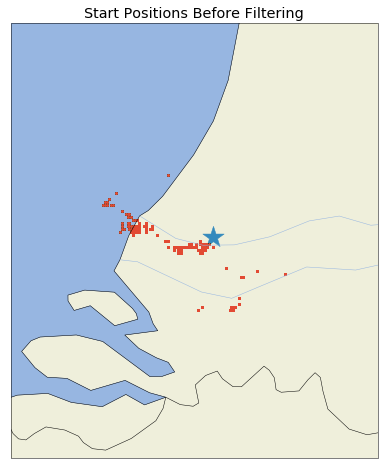

In [15]:
# Plot start positions before any filtering to map
aismap.plot_to_map(size = (8, 8), longitude = ais_dropped['StartLongitude'], latitude = ais_dropped['StartLatitude'])
plt.title("Start Positions Before Filtering")

Text(0.5,1,u'End Positions Before Filtering')

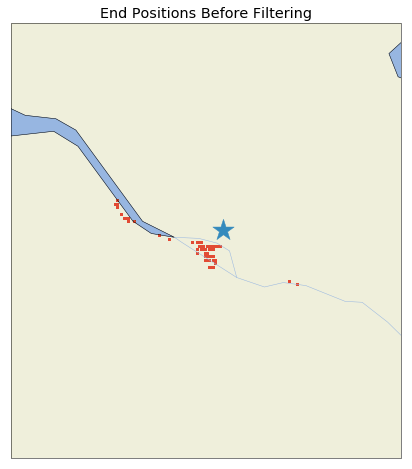

In [16]:
# Plot end positions before any filtering to map
aismap.plot_to_map(size = (8, 8), longitude = ais_dropped['EndLongitude'], latitude = ais_dropped['EndLatitude'])
plt.title("End Positions Before Filtering")

In [17]:
# Get rid of trips that leave our zone (2.45 - 10.66 / 51.49 - 55.06)

outside_long_mask = (ais_dropped['Longitude'] < 2.45) | (ais_dropped['Longitude'] > 10.66)
outside_lat_mask = (ais_dropped['Latitude'] < 51.49) | (ais_dropped['Latitude'] > 55.06)

outside_rec_mask = outside_long_mask | outside_lat_mask

outside_trip_ids = ais_dropped['TripID'][outside_rec_mask].unique()
outside_trip_mask = ~ais_dropped['TripID'].isin(outside_trip_ids)
ais_zoned = ais_dropped[outside_trip_mask]

Text(0.5,1,u'All Positions After Filtering to Our Zone')

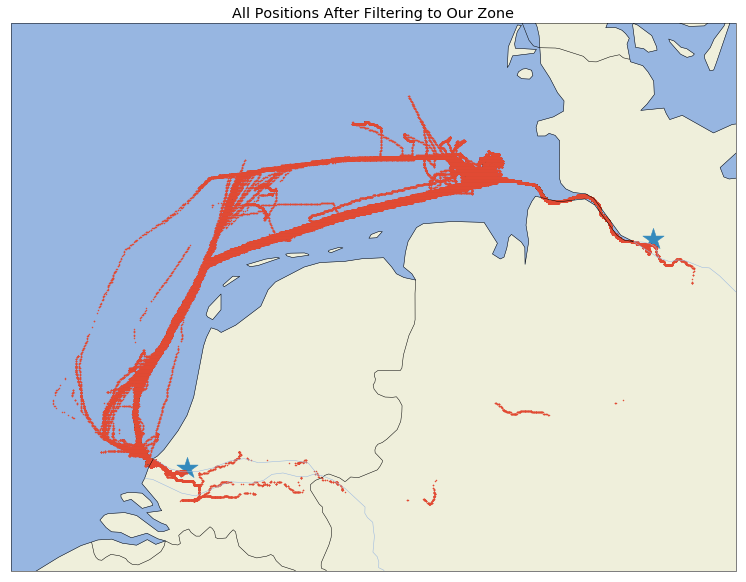

In [18]:
aismap.plot_to_map(size = (13, 13), longitude = ais_zoned['Longitude'], latitude = ais_zoned['Latitude'])
plt.title("All Positions After Filtering to Our Zone")

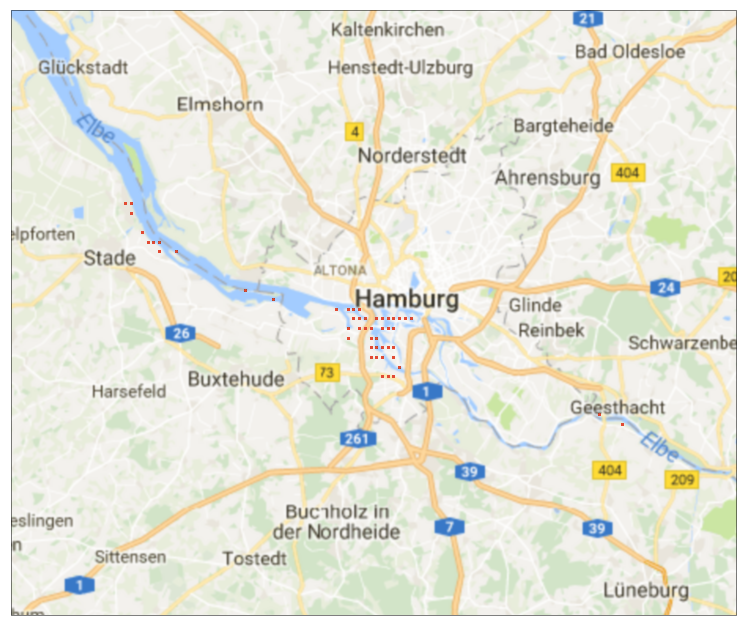

In [19]:
minlat = ais_zoned['EndLatitude'].min() - 0.2
maxlat = ais_zoned['EndLatitude'].max() + 0.2
minlong = ais_zoned['EndLongitude'].min() - 0.2
maxlong = ais_zoned['EndLongitude'].max() + 0.2

aismap.plot_google_map((minlong, maxlong, minlat, maxlat))
plt.scatter(x = ais_zoned['EndLongitude'], y = ais_zoned['EndLatitude'] , transform = ccrs.PlateCarree(), s = 1)

In [20]:
# Get times finish line is crossed, by trips that do cross it
finish_line_ts = ais_zoned[ais_zoned['Longitude'] > 9.81].groupby('TripID')['time'].min()

# Only keep trips that do cross the finish line
ais_ham_zoned = ais_zoned[ais_zoned['TripID'].isin(finish_line_ts.index)]

#Set EndTime to the time the ship first appears behind the finish line
for tripid in finish_line_ts.index :
    ais_ham_zoned.loc[ais_ham_zoned['TripID'] == tripid, 'EndTime'] = finish_line_ts.loc[tripid]

# Throw out all records after the finish line was crossed
ais_ham_zoned = ais_ham_zoned[ais_ham_zoned['time'] <= ais_ham_zoned['EndTime']]

/Users/jankaiser/anaconda2/lib/python2.7/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


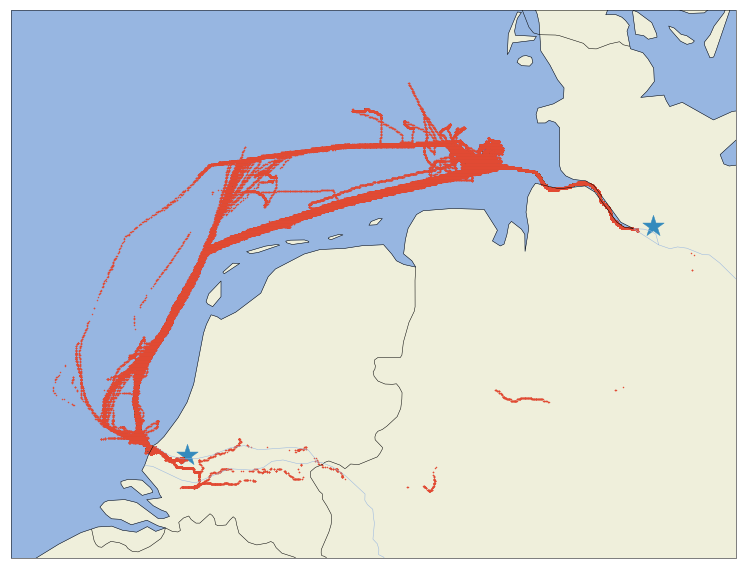

In [21]:
aismap.plot_to_map(size = (13, 13), longitude = ais_ham_zoned['Longitude'], latitude = ais_ham_zoned['Latitude'])

In [22]:
ais_tts = ais_ham_zoned
ais_tts.is_copy = False   # Hack to silence SettingWithCopyWarning

# Add time for the entire trip to the data
ais_tts['TravelTime'] = ais_tts['EndTime'] - ais_tts['StartTime']
ais_tts['TravelTimeMins'] = ais_tts['TravelTime'].transform(lambda x : x.total_seconds() / 60)

# Add time remaining until arrival at destination
ais_tts['remainingTT'] = ais_tts['EndTime'] - ais_tts['time']
ais_tts['remainingMins'] = ais_tts['remainingTT'].transform(lambda x : x.total_seconds() / 60)

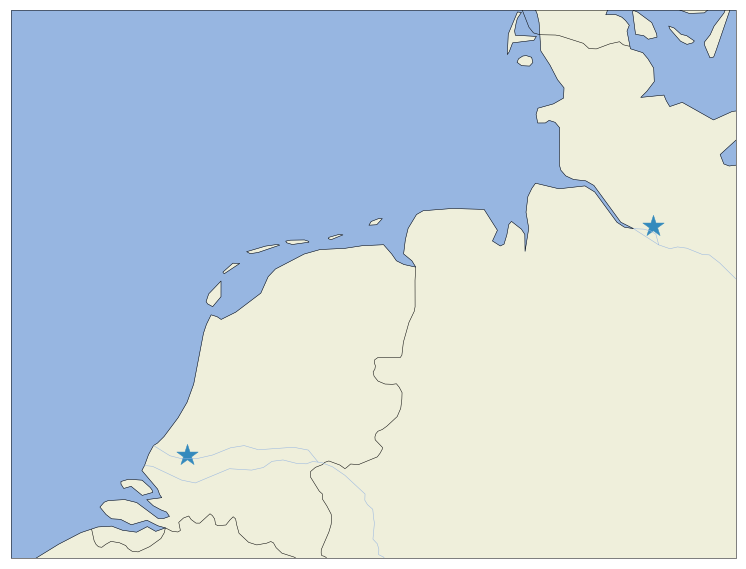

In [23]:
aismap.plot_trips(ais_tts, 'TravelTime')

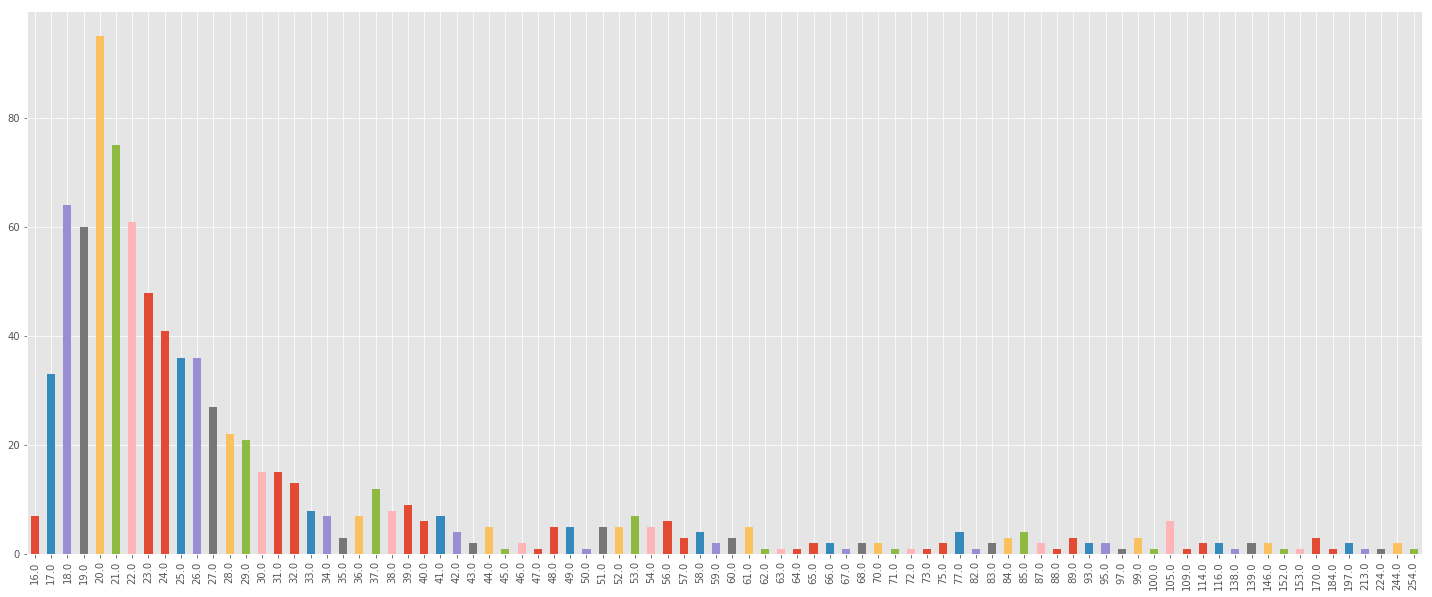

In [24]:
travel_times = ais_tts.groupby('TripID')['TravelTime'].max()
travel_times = travel_times.transform(lambda x : x.total_seconds() // 3600)
travel_times.value_counts().sort_index().plot.bar(figsize = (25, 10))

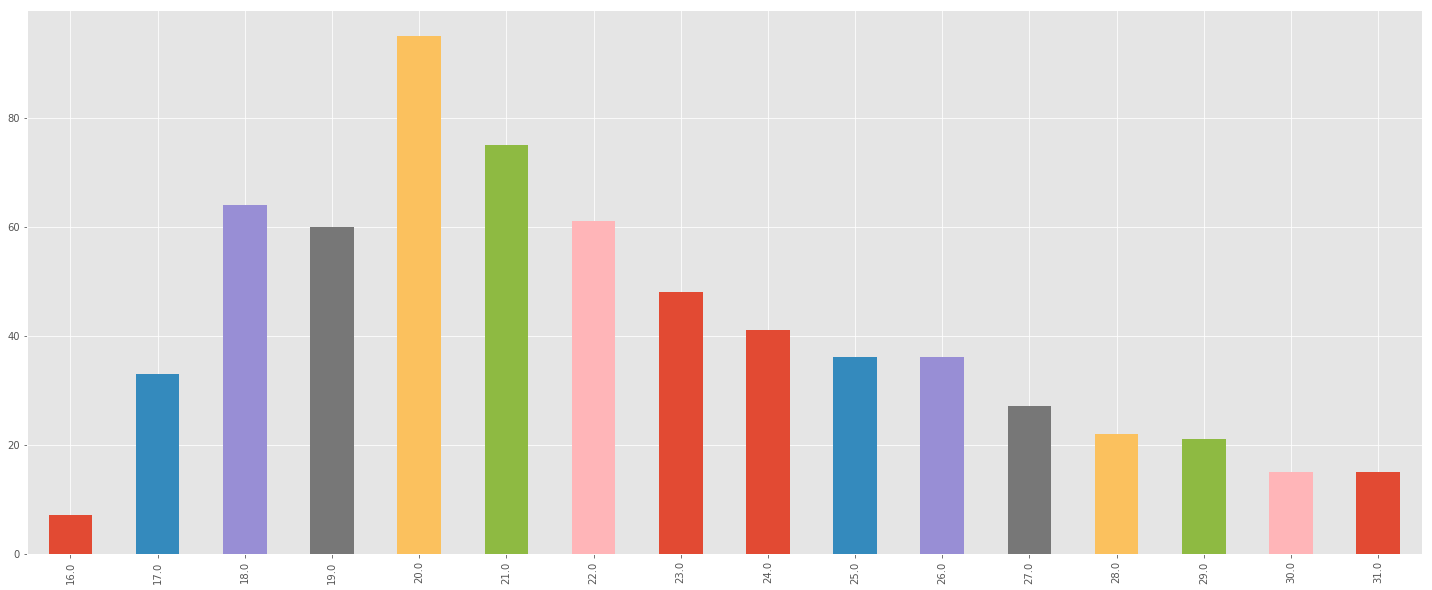

In [25]:
travel_times[travel_times < travel_times.quantile(.75)].value_counts().sort_index().plot.bar(figsize = (25, 10))

In [26]:
# Only keep majority of shorter trips
ais_shortmaj = ais_tts[ais_tts['TravelTime'] < ais_tts['TravelTime'].quantile(.75)]

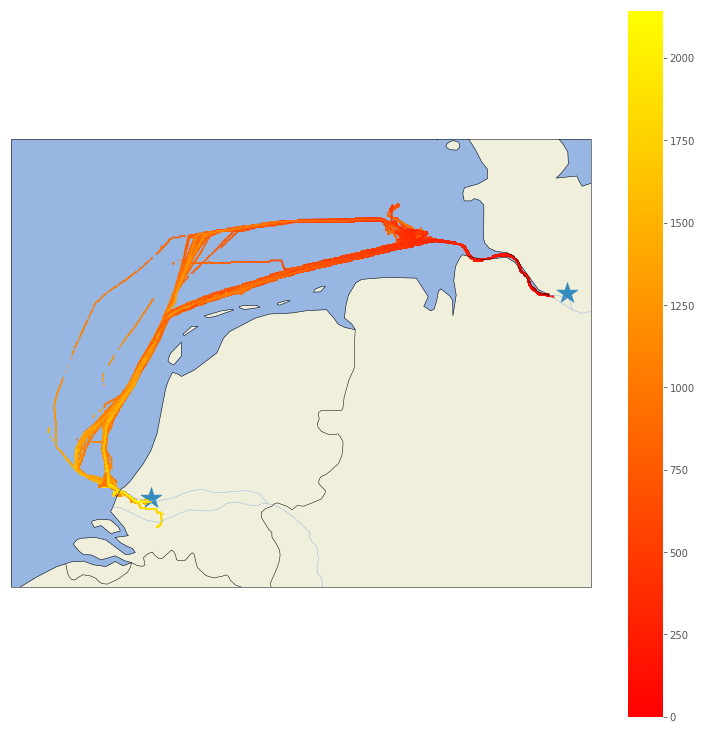

In [28]:
aismap.col_plot_to_map(size = (13, 13), longitude = ais_shortmaj['Longitude'], latitude = ais_shortmaj['Latitude'], col= ais_shortmaj['remainingMins'])

In [29]:
# Get and plot the longest trip in the data set
longest_trip = ais_shortmaj[ais_shortmaj['TravelTime'] == ais_shortmaj['TravelTime'].max()]
longest_trip.head()

,TripID,StartLatitude,StartLongitude,StartTime,EndLatitude,EndLongitude,EndTime,time,Length,Breadth,...,Longitude,SOG,COG,TH,Destination,Callsign,TravelTime,TravelTimeMins,remainingTT,remainingMins
382931,564667,51.94,4.05,2016-05-28 06:46:00,53.52,9.92,2016-05-29 18:31:00,2016-05-28 08:38:00,184.0,26.0,...,3.90,14.0,349.0,347.0,DEHAM,5BSL2,1 days 11:45:00,2145.0,1 days 09:53:00,2033.0
383053,564667,51.94,4.05,2016-05-28 06:46:00,53.52,9.92,2016-05-29 18:31:00,2016-05-28 07:10:00,184.0,26.0,...,4.08,6.0,40.0,26.0,DEHAM,5BSL2,1 days 11:45:00,2145.0,1 days 11:21:00,2121.0
383129,564667,51.94,4.05,2016-05-28 06:46:00,53.52,9.92,2016-05-29 18:31:00,2016-05-28 06:46:00,184.0,26.0,...,4.05,1.6,175.0,292.0,DEHAM,5BSL2,1 days 11:45:00,2145.0,1 days 11:45:00,2145.0
383130,564667,51.94,4.05,2016-05-28 06:46:00,53.52,9.92,2016-05-29 18:31:00,2016-05-28 06:49:00,184.0,26.0,...,4.05,1.3,267.0,12.0,DEHAM,5BSL2,1 days 11:45:00,2145.0,1 days 11:42:00,2142.0
383131,564667,51.94,4.05,2016-05-28 06:46:00,53.52,9.92,2016-05-29 18:31:00,2016-05-28 06:52:00,184.0,26.0,...,4.05,1.0,89.0,75.0,DEHAM,5BSL2,1 days 11:45:00,2145.0,1 days 11:39:00,2139.0


Text(0.5,1,u'Longest Trip in the Data Set')

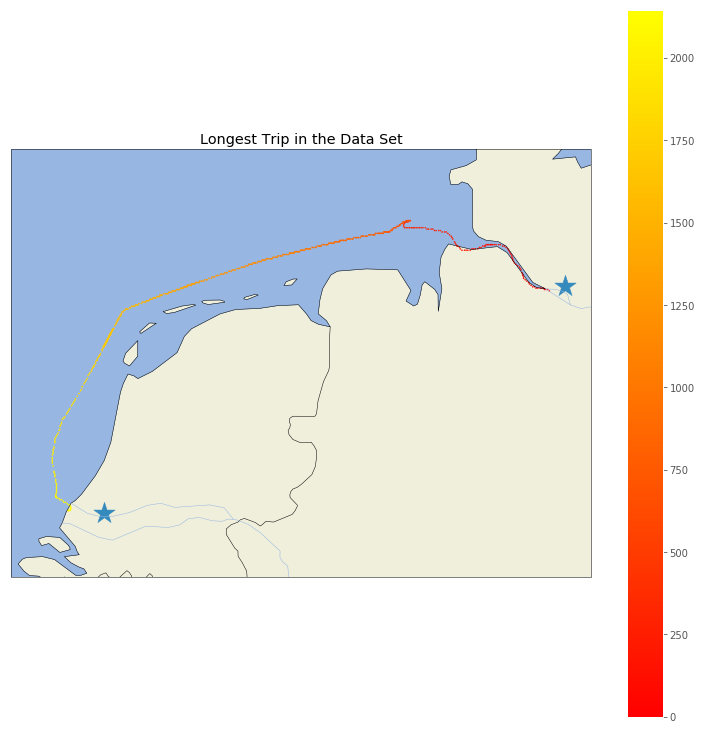

In [30]:
aismap.col_plot_to_map(size = (13, 13), longitude = longest_trip['Longitude'], latitude = longest_trip['Latitude'], col = longest_trip['remainingMins'])
plt.title("Longest Trip in the Data Set")

In [31]:
ais_dists = ais_shortmaj
ais_dists.is_copy = False

ais_dists['dist_to_end'] = ais_dists.apply(lambda x : aismap.route_dist_to_ham(x['Latitude'], x['Longitude']), axis = 1)
ais_dists.head()

,TripID,StartLatitude,StartLongitude,StartTime,EndLatitude,EndLongitude,EndTime,time,Length,Breadth,...,SOG,COG,TH,Destination,Callsign,TravelTime,TravelTimeMins,remainingTT,remainingMins,dist_to_end
0,21109,51.94,4.05,2016-01-21 04:32:00,53.53,9.91,2016-01-22 05:09:00,2016-01-21 22:04:00,269.0,32.0,...,14.7,81.0,80.0,HAMBURG,5BND2,1 days 00:37:00,1477.0,07:05:00,425.0,146.827424
1,21109,51.94,4.05,2016-01-21 04:32:00,53.53,9.91,2016-01-22 05:09:00,2016-01-21 22:05:00,269.0,32.0,...,14.7,80.0,80.0,HAMBURG,5BND2,1 days 00:37:00,1477.0,07:04:00,424.0,146.185516
2,21109,51.94,4.05,2016-01-21 04:32:00,53.53,9.91,2016-01-22 05:09:00,2016-01-21 22:06:00,269.0,32.0,...,14.7,81.0,80.0,HAMBURG,5BND2,1 days 00:37:00,1477.0,07:03:00,423.0,146.185516
3,21109,51.94,4.05,2016-01-21 04:32:00,53.53,9.91,2016-01-22 05:09:00,2016-01-21 22:07:00,269.0,32.0,...,14.7,80.0,80.0,HAMBURG,5BND2,1 days 00:37:00,1477.0,07:02:00,422.0,145.544334
4,21109,51.94,4.05,2016-01-21 04:32:00,53.53,9.91,2016-01-22 05:09:00,2016-01-21 22:08:00,269.0,32.0,...,14.7,81.0,80.0,HAMBURG,5BND2,1 days 00:37:00,1477.0,07:01:00,421.0,144.903944


In [38]:
ais_tfeats = ais_dists
ais_tfeats.is_copy = False

ais_tfeats['hour_of_day'] = ais_tfeats['time'].dt.hour
ais_tfeats['weekday'] = ais_tfeats['time'].dt.dayofweek
ais_tfeats['day_of_month'] = ais_tfeats['time'].dt.day
ais_tfeats['month'] = ais_tfeats['time'].dt.month

In [40]:
ais_tfeats['weekday'].describe()

count    831853.000000
mean          2.947164
std           1.955274
min           0.000000
25%           1.000000
50%           3.000000
75%           5.000000
max           6.000000
Name: weekday, dtype: float64

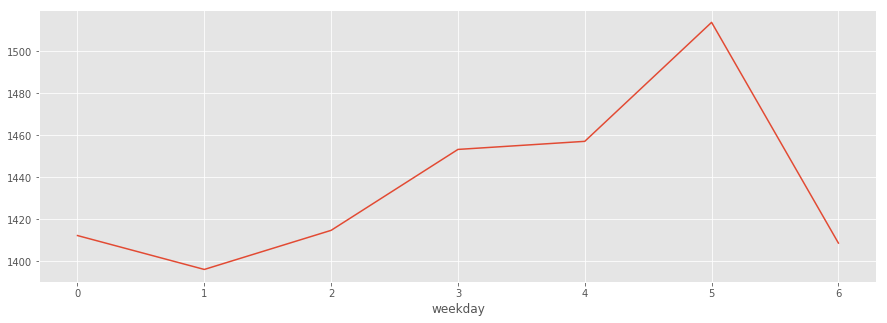

In [53]:
ais_tfeats.groupby('weekday')['TravelTimeMins'].mean().plot(figsize = (15, 5))

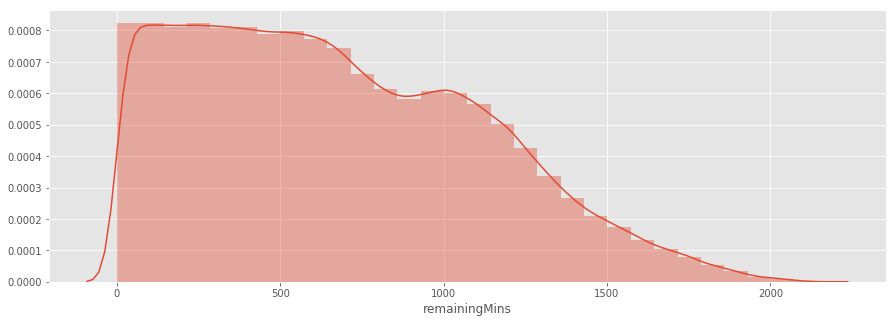

In [32]:
plt.figure(figsize = (15, 5))
sns.distplot(ais_tfeats['remainingMins'], bins = 30)

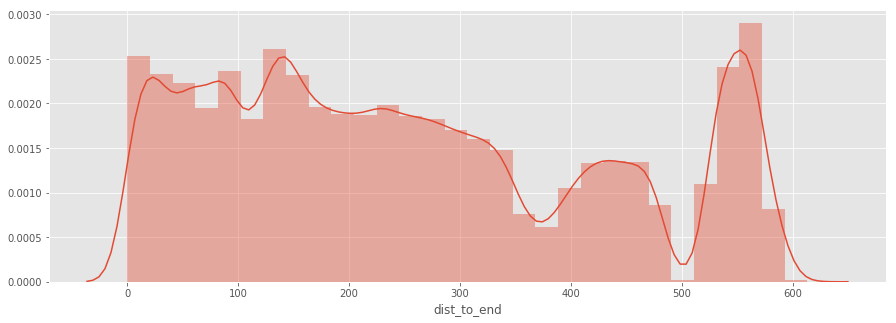

In [34]:
plt.figure(figsize = (15, 5))
sns.distplot(ais_tfeats['dist_to_end'], bins = 30)

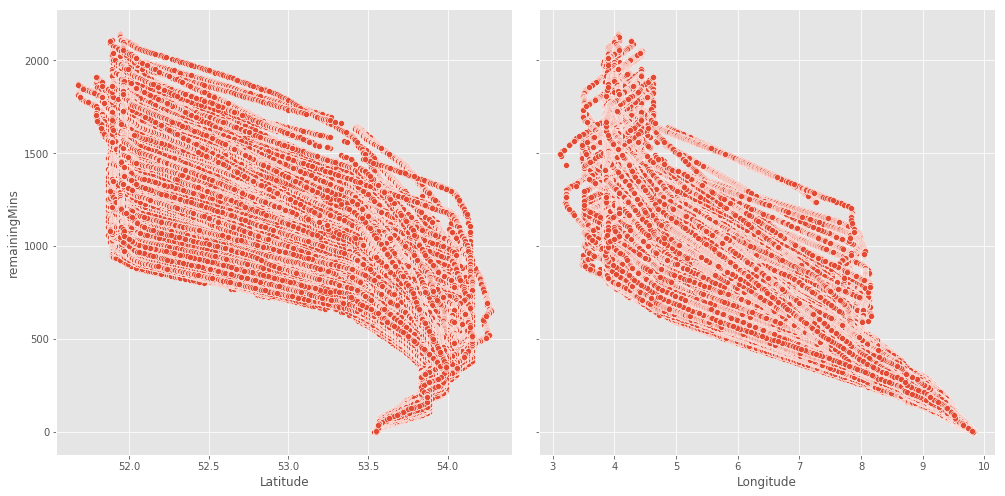

In [41]:
sns.pairplot(ais_tfeats, x_vars = ['Latitude', 'Longitude'], y_vars = 'remainingMins', size = 7)

In [42]:
ais_tfeats.head()

,TripID,StartLatitude,StartLongitude,StartTime,EndLatitude,EndLongitude,EndTime,time,Length,Breadth,...,COG,TH,Destination,Callsign,TravelTime,TravelTimeMins,remainingTT,remainingMins,dist_to_end,weekday
0,21109,51.94,4.05,2016-01-21 04:32:00,53.53,9.91,2016-01-22 05:09:00,2016-01-21 22:04:00,269.0,32.0,...,81.0,80.0,HAMBURG,5BND2,1 days 00:37:00,1477.0,07:05:00,425.0,146.827424,3
1,21109,51.94,4.05,2016-01-21 04:32:00,53.53,9.91,2016-01-22 05:09:00,2016-01-21 22:05:00,269.0,32.0,...,80.0,80.0,HAMBURG,5BND2,1 days 00:37:00,1477.0,07:04:00,424.0,146.185516,3
2,21109,51.94,4.05,2016-01-21 04:32:00,53.53,9.91,2016-01-22 05:09:00,2016-01-21 22:06:00,269.0,32.0,...,81.0,80.0,HAMBURG,5BND2,1 days 00:37:00,1477.0,07:03:00,423.0,146.185516,3
3,21109,51.94,4.05,2016-01-21 04:32:00,53.53,9.91,2016-01-22 05:09:00,2016-01-21 22:07:00,269.0,32.0,...,80.0,80.0,HAMBURG,5BND2,1 days 00:37:00,1477.0,07:02:00,422.0,145.544334,3
4,21109,51.94,4.05,2016-01-21 04:32:00,53.53,9.91,2016-01-22 05:09:00,2016-01-21 22:08:00,269.0,32.0,...,81.0,80.0,HAMBURG,5BND2,1 days 00:37:00,1477.0,07:01:00,421.0,144.903944,3


In [43]:
ais_tfeats.columns

Index([u'TripID', u'StartLatitude', u'StartLongitude', u'StartTime',
       u'EndLatitude', u'EndLongitude', u'EndTime', u'time', u'Length',
       u'Breadth', u'Draught', u'Latitude', u'Longitude', u'SOG', u'COG',
       u'TH', u'Destination', u'Callsign', u'TravelTime', u'TravelTimeMins',
       u'remainingTT', u'remainingMins', u'dist_to_end', u'weekday'],
      dtype='object')

In [44]:
ais_learners = ais_tfeats[['TripID', 'time', 'Length', 'Breadth', 'Draught', 'Latitude', 'Longitude',
                             'SOG', 'COG', 'TH', 'weekday', 'remainingMins']]
ais_learners = ais_learners.dropna()
ais_learners.head()

,TripID,time,Length,Breadth,Draught,Latitude,Longitude,SOG,COG,TH,weekday,remainingMins
0,21109,2016-01-21 22:04:00,269.0,32.0,10.64,53.95,7.82,14.7,81.0,80.0,3,425.0
1,21109,2016-01-21 22:05:00,269.0,32.0,10.64,53.95,7.83,14.7,80.0,80.0,3,424.0
2,21109,2016-01-21 22:06:00,269.0,32.0,10.64,53.95,7.83,14.7,81.0,80.0,3,423.0
3,21109,2016-01-21 22:07:00,269.0,32.0,10.64,53.95,7.84,14.7,80.0,80.0,3,422.0
4,21109,2016-01-21 22:08:00,269.0,32.0,10.64,53.95,7.85,14.7,81.0,80.0,3,421.0


In [45]:
X = ais_learners[['Latitude', 'Longitude', 'SOG', 'weekday']]
y = ais_learners['remainingMins']

In [46]:
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

cv_splits = list(GroupKFold(n_splits = 10).split(X, y, groups = ais_learners['TripID']))

In [47]:
# Create a train-test split
train_indices, test_indicies = cv_splits[0]
X_train, X_test = X.iloc[train_indices], X.iloc[test_indicies]
y_train, y_test = y.iloc[train_indices], y.iloc[test_indicies]

In [48]:
from sklearn.linear_model import LinearRegression

lin = LinearRegression()

lin_params = dict(normalize = [True, False])
lin_grid = GridSearchCV(lin, lin_params, cv = cv_splits, return_train_score = True, scoring = 'neg_mean_absolute_error')
lin_grid.fit(X, y)

pd.DataFrame(lin_grid.cv_results_)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_normalize,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,...,split7_test_score,split7_train_score,split8_test_score,split8_train_score,split9_test_score,split9_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,0.119619,0.004804,-96.867845,-96.730298,True,{u'normalize': True},1,-91.295377,-97.343197,-97.195234,...,-91.106881,-97.654734,-96.701545,-96.897746,-104.469975,-95.978365,0.032565,0.001131,4.321659,0.560734
1,0.104894,0.004815,-96.867845,-96.730298,False,{u'normalize': False},2,-91.295377,-97.343197,-97.195234,...,-91.106881,-97.654734,-96.701545,-96.897746,-104.469975,-95.978365,0.012488,0.000903,4.321659,0.560734


In [ ]:
from sklearn.neighbors import KNeighborsRegressor

knn = KNeighborsRegressor()

knn_params = dict(n_neighbors = range(1, 50), weights = ['uniform', 'distance'])
knn_rand = RandomizedSearchCV(knn, knn_params, cv = cv_splits, return_train_score = True, scoring = 'neg_mean_absolute_error', n_iter = 10)
knn_rand.fit(X, y)

pd.DataFrame(knn_rand.cv_results_)

In [ ]:
knn_best = KNeighborsRegressor(n_neighbors = 41, weights = 'distance')
knn_best.fit(X_train, y_train)

knn_predicts = knn_best.predict(X_test)

In [ ]:
knn_predicts_diffs = knn_predicts - y_test

In [ ]:
knn_predicts_frame = pd.DataFrame({'correct': y_test, 'knn_predicted': knn_predicts, 'diff': knn_predicts_diffs})
knn_predicts_frame['abs_error'] = knn_predicts_frame['diff'].transform(lambda x: abs(x))
knn_predicts_frame = knn_predicts_frame.sort_values('correct')
knn_predicts_frame['abs_error'].describe()

In [ ]:
plt.figure(figsize = (15, 5))
plt.plot(knn_predicts_frame['correct'], knn_predicts_frame['diff'])

In [ ]:
from sklearn.ensemble import RandomForestRegressor

rfo = RandomForestRegressor()
rfo_params = dict(n_estimators = range(1, 10), max_depth = range(5,15))
rfo_rand = RandomizedSearchCV(rfo, rfo_params, cv = cv_splits, return_train_score = True, scoring = 'neg_mean_absolute_error', n_iter = 10)
rfo_rand.fit(X, y)

pd.DataFrame(rfo_rand.cv_results_)